In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import shap, datetime, warnings
warnings.filterwarnings('ignore')

In [2]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))

In [3]:
sentiment_cols = [i for i in df.columns if any(x in i for x in ['Article Count', 'Tone', 'llm'])] + [i for i in df.columns if i.startswith('c') or i.startswith('v')]
time_cols = ['hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10','month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8','month_of_year_9','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4']
self_finance_vars = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and all(x not in i for x in ['BNO','JETS','IYT','ITA'])]
oil_vars          = [i for i in df.columns if 'lag' in i and 'BNO' in i]
etf_finance_vars  = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and any(x in i for x in ['JETS','IYT','ITA'])]
finance_vars = self_finance_vars + oil_vars + etf_finance_vars

In [68]:
sentiment_cols

['Article Count_cum04_lag01',
 'Article Count_cum16_lag01',
 'Article Count_cum48_lag01',
 'Article Count_cum96_lag01',
 'Article Count_lag01',
 'Tone_cum04_lag01',
 'Tone_cum16_lag01',
 'Tone_cum48_lag01',
 'Tone_cum96_lag01',
 'Tone_lag01',
 'llm_dimension_00_cum04_lag01',
 'llm_dimension_00_cum16_lag01',
 'llm_dimension_00_cum48_lag01',
 'llm_dimension_00_cum96_lag01',
 'llm_dimension_00_lag01',
 'llm_dimension_01_cum04_lag01',
 'llm_dimension_01_cum16_lag01',
 'llm_dimension_01_cum48_lag01',
 'llm_dimension_01_cum96_lag01',
 'llm_dimension_01_lag01',
 'llm_dimension_02_cum04_lag01',
 'llm_dimension_02_cum16_lag01',
 'llm_dimension_02_cum48_lag01',
 'llm_dimension_02_cum96_lag01',
 'llm_dimension_02_lag01',
 'llm_dimension_03_cum04_lag01',
 'llm_dimension_03_cum16_lag01',
 'llm_dimension_03_cum48_lag01',
 'llm_dimension_03_cum96_lag01',
 'llm_dimension_03_lag01',
 'llm_dimension_04_cum04_lag01',
 'llm_dimension_04_cum16_lag01',
 'llm_dimension_04_cum48_lag01',
 'llm_dimension_04_cum

In [4]:
# Define the different sets of features to try
feature_sets = {
    'all': sentiment_cols + finance_vars + time_cols 
}

In [5]:
y_cols = ['Volume']
y = df[y_cols]

In [6]:
# Train/test splitting
split_val  = round(0.8 * len(y))
split_test = round(0.9 * len(y))

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

In [7]:
predictions = df[['date','ticker','Volume']+time_cols]
predictions = predictions.iloc[split_val:, :]
predictions.rename(columns={'Volume': 'Actual'}, inplace=True)

In [8]:
# Add the tuned and retrained models as well
model = pickle.load(open(f'../../output/models/LightGBM/lightgbm_all_tuned_retrained.pkl', 'rb'))

x_cols = feature_sets['all']
x = df[x_cols]
x_train = x[:split_val]
x_val   = x[split_val:split_test]
x_test  = x[split_test:]

# Normalize the features to [0,1]
sc2 = MinMaxScaler(feature_range=(0, 1))

x_train = sc2.fit_transform(x_train)
x_val   = sc2.transform(x_val)
x_test  = sc2.transform(x_test)
x_eval = np.concatenate((x_val, x_test), axis=0)

In [9]:
# sample 1000 rows from x_eval
np.random.seed(42)
x_sample = x_eval[np.random.choice(x_eval.shape[0], size=1000, replace=False), :]

In [10]:
# shap values
explainer = shap.TreeExplainer(model, x_sample, feature_names=x.columns)
shap_values = explainer(x_sample, check_additivity=False)

100%|===================| 999/1000 [14:55<00:00]        

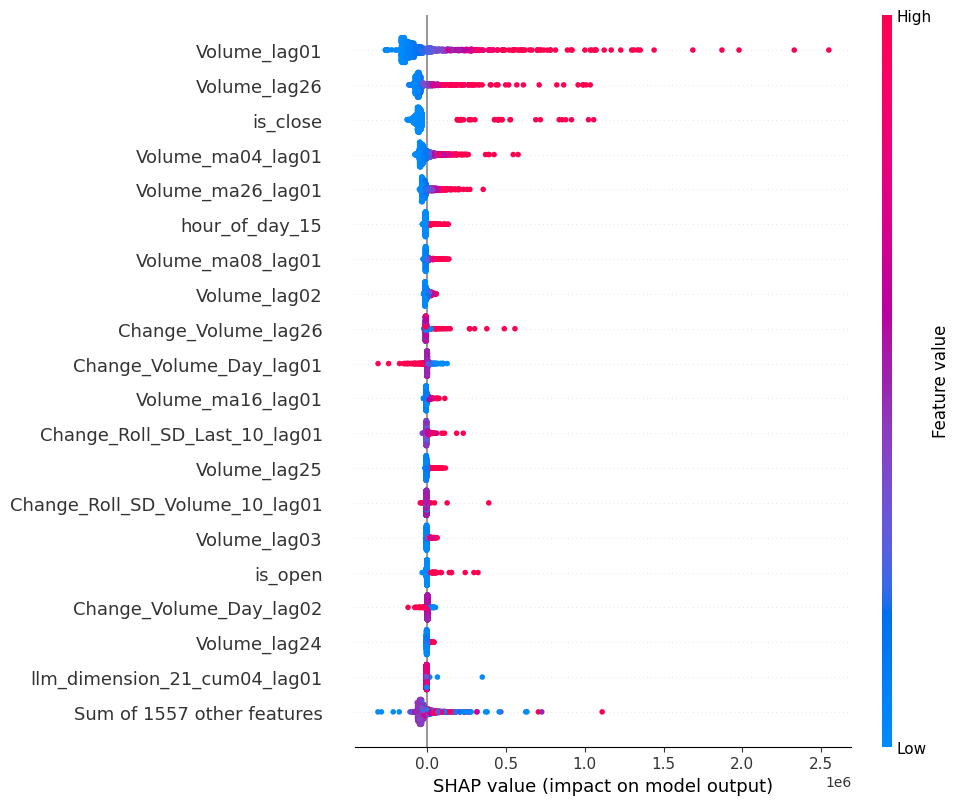

<Figure size 640x480 with 0 Axes>

In [11]:
shap.plots.beeswarm(shap_values, max_display=20)
plt.savefig('../../output/shap_beeswarm_all.png', dpi=600)

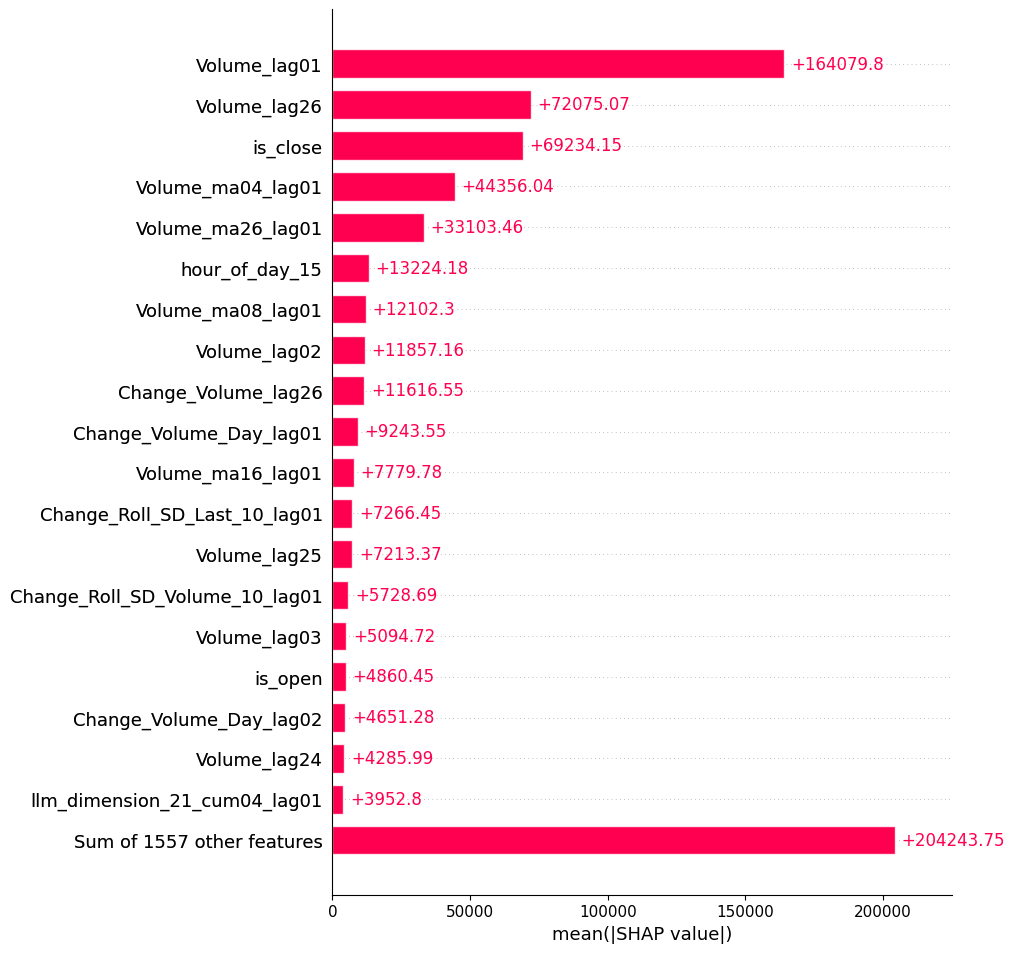

In [47]:
shap.plots.bar(shap_values.abs.mean(0), max_display=20)

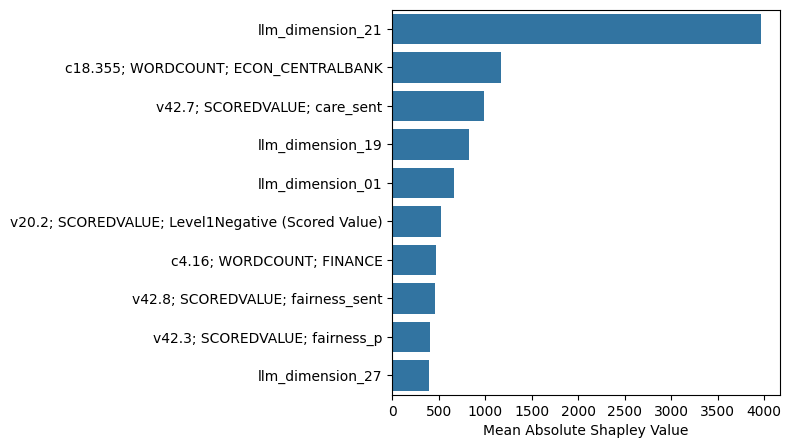

In [83]:
# Identify the unique sentiment variable names
sentiment_vars = [i.replace('_lag01','').replace('_cum04','').replace('_cum16','').replace('_cum48','').replace('_cum96','') for i in sentiment_cols]
sentiment_vars = list(set(sentiment_vars))

df_shap = pd.DataFrame(shap_values.values, columns=x.columns)

for i in sentiment_vars:
    df_shap[i] = np.abs(df_shap[[j for j in df_shap.columns if i in j]].sum(axis=1))
df_shap
df_shap = df_shap[sentiment_vars]
df_agg = df_shap.mean(axis=0).to_frame(name='Mean Absolute Shapley Value').reset_index()

# limit to top variables
df_agg = df_agg.nlargest(10, 'Mean Absolute Shapley Value')

plt.figure(figsize=(5, 5))

sns.barplot(
    data=df_agg, 
    x='Mean Absolute Shapley Value', 
    y='index')

plt.ylabel('')
plt.savefig('../../output/shap_sentiment_contributions.png', dpi=600)

In [49]:
shap_values[:, 'llm_dimension_21_cum04_lag01']

.values =
array([ -2993.39722962,  -4714.63114841,  -3277.08554147,  -3198.59262978,
        -9607.64636004,  -3526.94914651,  -3705.17899841,  -3467.48926763,
        -5109.57042826,  -3074.12991683,  -3435.93364226,  -3360.58006734,
        -3380.49384786,  -3367.18533566,  -3402.21734247,  -3808.60000049,
        -2559.23481681,  -3812.57973385,  -3252.93976266,  -3643.20971162,
        -7658.04836028,  -3203.91608927,  -3415.27143851,  -3462.92468835,
        -3115.91056078,  -3256.1526888 ,  -3481.18724539,  -3362.42397517,
        -3520.48161387,  -3318.94954363,  -3432.30233708,  -3625.61425043,
        -3342.0858133 ,  -3654.27219632,  -3822.2092219 ,  -4220.68247768,
        -3520.58808001,   1589.15030893,  -3410.58728856,  -3394.5756447 ,
        -3546.29626648,  -3587.814758  ,  -3525.95655579,  -3353.32283437,
        -4568.98006039,  -3202.06216359,  -3623.4972938 ,  -3425.81378741,
        -3223.76779998,  -6083.59984252,  -3536.52083745,  -3312.37401208,
        -3867.0

(array([998.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ -9607.64636004,  26317.32103746,  62242.28843496,  98167.25583246,
        134092.22322996, 170017.19062746, 205942.15802496, 241867.12542246,
        277792.09281996, 313717.06021746, 349642.02761496]),
 <BarContainer object of 10 artists>)

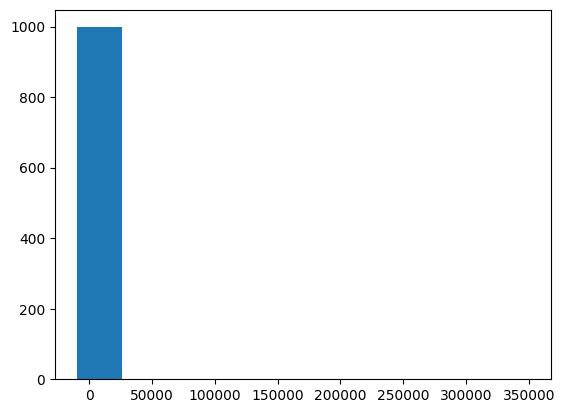

In [43]:
plt.hist(
        shap_values[:, 'llm_dimension_21_cum04_lag01'].values,
    )

In [23]:
# Question: how much do the sentiment variables contribute to the model?
df_shap = pd.DataFrame(shap_values.values, columns=x.columns)
df_shap = df_shap[sentiment_cols]
df_shap_sum_sentiment = df_shap.sum(axis=1).to_frame(name='shap_sum_sentiment')
df_shap_sum_sentiment['symlog'] = df_shap_sum_sentiment.apply(lambda x: np.sign(x) * np.log10(np.abs(x)))
df_shap_sum_sentiment

,shap_sum_sentiment,symlog
0,3359.832602,3.526318
1,-18731.272095,-4.272567
2,-7529.607311,-3.876772
3,-7337.103714,-3.865525
4,42865.424247,4.632107
...,...,...
995,-7658.651168,-3.884152
996,-6933.792339,-3.840971
997,-7941.476373,-3.899901
998,3759.292835,3.575106


<Axes: xlabel='shap_sum_sentiment', ylabel='Percent'>

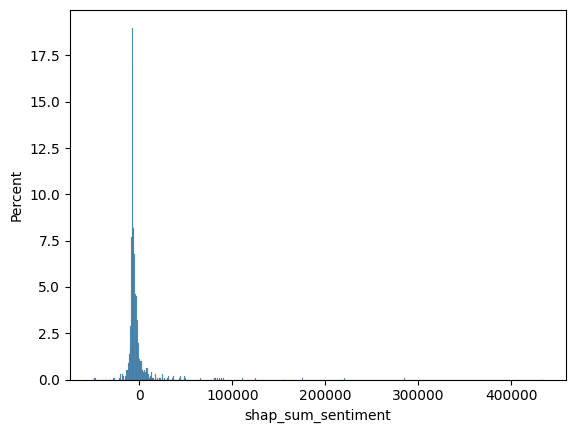

In [31]:
sns.histplot(df_shap_sum_sentiment['shap_sum_sentiment'], stat='percent')

<Axes: xlabel='symlog', ylabel='Percent'>

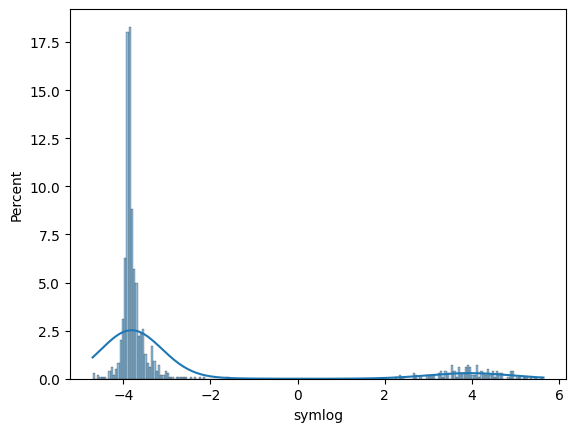

In [25]:
sns.histplot(df_shap_sum_sentiment['symlog'], bins=200, kde=True, stat='percent')